In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm
from numpy.linalg import norm

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp, centers
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections
from External.data_loader import data_loader
from External.ICT.reduce_to_mst import MST
from External.create_k_nearest import patch_together



plt.style.use('standard.mplstyle')

cv2 package not present. No movies possible


In [5]:
# Hyperparameters
mode = "K_Nearest+Density2"
metric = "euclidean"
dataset = "pancreas_full"

threshold = 12

# for the filename
parameters = "2-0_5-t12"

In [6]:
start = time.time()

# load the dataset & UMAP embedding (if dim > 2, othervise embedding=position)
position, labels, embedding = data_loader(dataset, True)

# calculate the clusters
if len(position[0]) > 500:
    pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))
else:
    pca = StandardScaler().fit_transform(position)

################################
###   apply the fitltering   ###
################################
from cluster_filter import cfilter
number_of_nodes = len(position)
ε, δ = 0.03, 0.1
r = 1 / (ε**2) * (int(np.log2(number_of_nodes - 1)) + 1 + np.log(1/δ))
k = int(np.sqrt(r))
k = np.min((k, number_of_nodes))

cluster_centers, labels, position, pca, embedding = cfilter(*k_means_pp(k, pca, return_labels=True), position, pca, embedding)
number_of_nodes = len(pca)
################################
unique_labels = np.unique(labels)


print("Time for data preperation: ", time.time()-start)

sklearn is done: 29.739600896835327
My own part is done: 2.618569850921631
Time for data preperation:  128.8692934513092


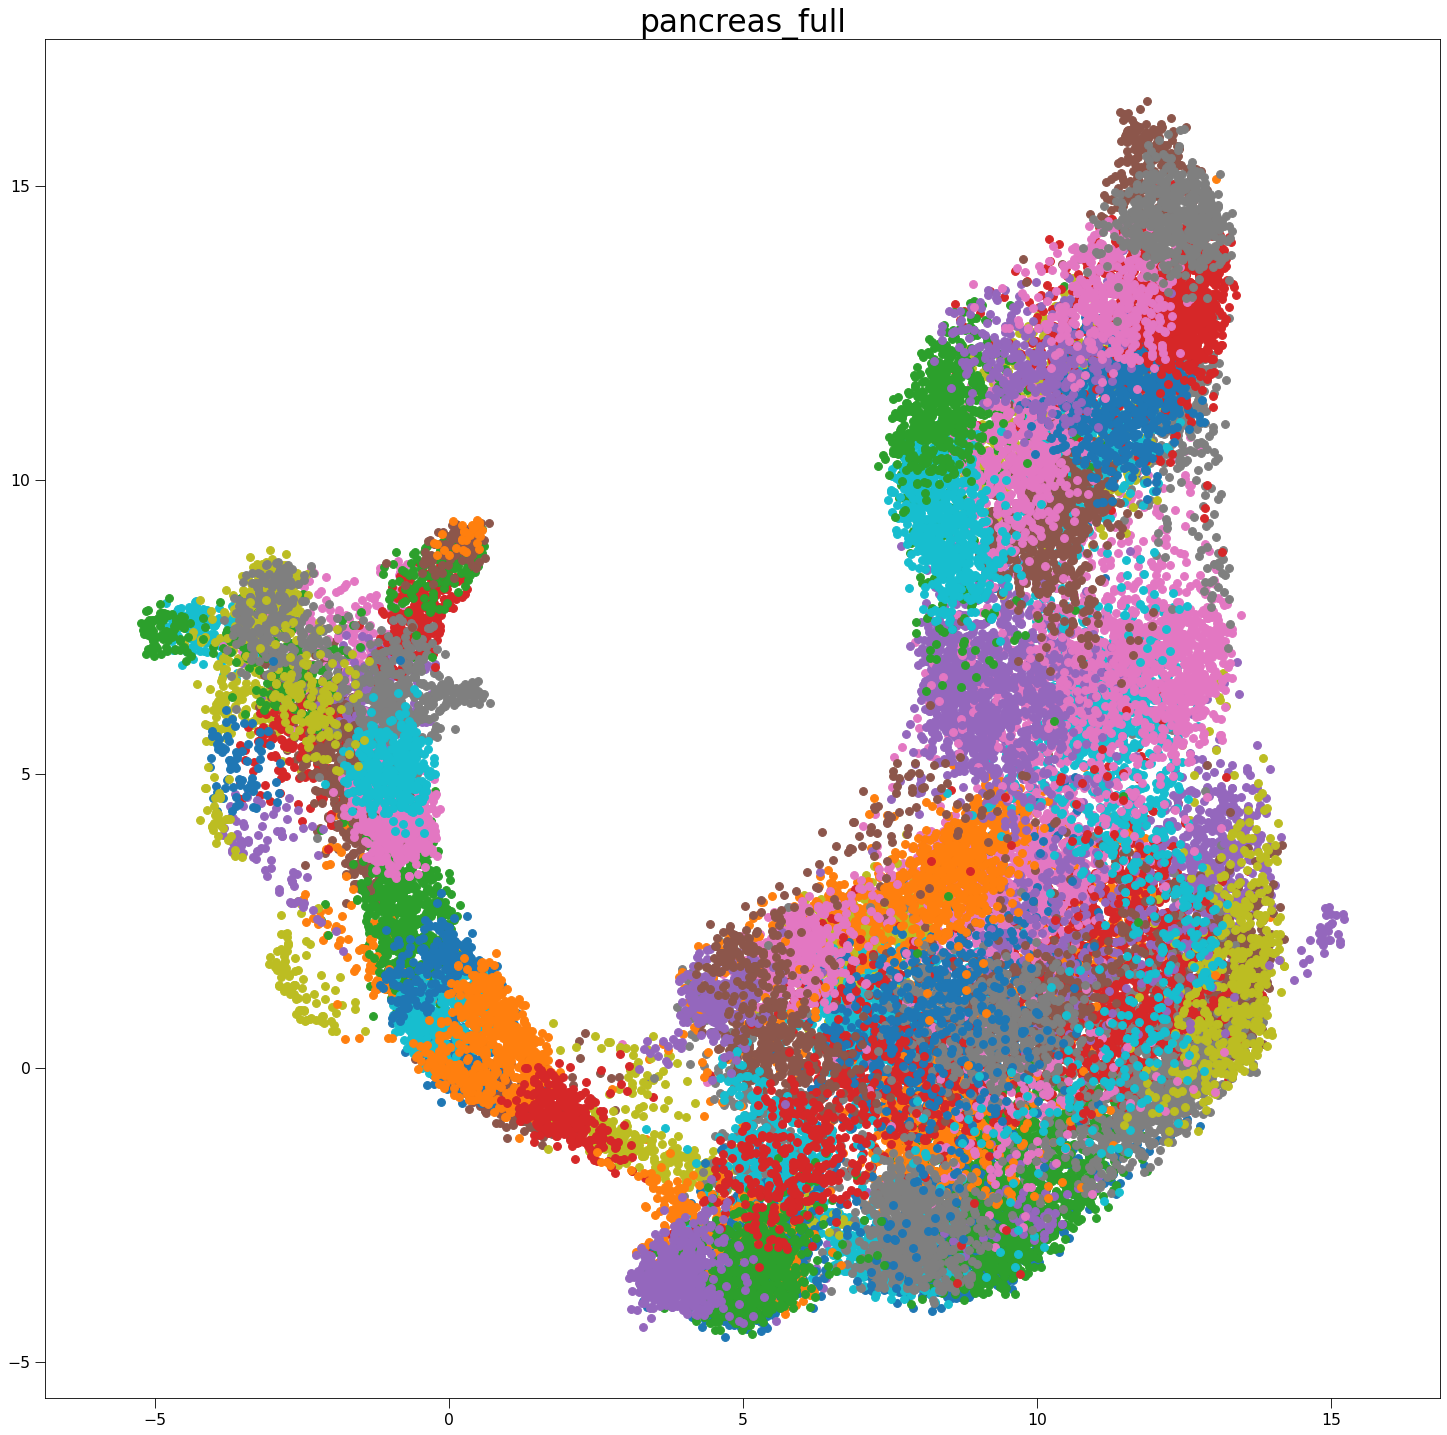

In [7]:
fig, ax = plt.subplots(1, figsize=(24,24))
plot_points(embedding, dataset, ax, labels)
ax.get_legend().remove()
plt.show()

In [8]:
components = []
node_labels = [None for _ in range(number_of_nodes)]
for label in np.sort(unique_labels):
    component = np.argwhere(label == labels).T
    assert len(component) == 1
    
    for node in component[0]:
        node_labels[node] = label
        
    components.append(component[0].tolist())

sub_ICTs = []

# Put the clusters with #nodes < threshold to the cluster of the nearest node
# PCA since clusters are computed in pca space!
distances = pairwise_distances(pca, pca)

cleaned_components = [False for _ in range(len(unique_labels))]

while True:
    
    for idx, component in enumerate(components):
        
        if cleaned_components[idx] == True:
            continue
        
        if len(component) <= threshold:
            
            for node in component:
                nearests = np.argsort(distances[node])
                for elem in nearests:
                    if elem not in component:
                        nearest = elem
                node_labels[node] = node_labels[nearest]
                components[node_labels[nearest]].append(node)
                cleaned_components[idx] = True
                continue
    
    break

new_components = []
new_node_labels = [None for _ in range(number_of_nodes)]
    
for idx, component in enumerate(components):
    if cleaned_components[idx] == False:
        new_components.append(component)
        for node in component:
            new_node_labels[node] = idx
            
unique_labels = np.unique(new_node_labels)
components = new_components
node_labels = new_node_labels

In [ ]:
for component in components:
    print(pca[component])

In [ ]:
p

In [ ]:

for component in tqdm(components):
    
    sub_number_of_nodes = len(component)
    
    sub_G, _ = create_graph(sub_number_of_nodes, mode, position=pca[component], k=11,
                            beta=2, delta=0.5, bridges=4)
    sub_G.indexEdges()

    break
    
fig, ax = plt.subplots(1,1)
plot_graph(sub_G, embedding[component], "ICT (UMAP)", ax, node_size=0)

sum_u = 0
for i, u in enumerate(sub_G.iterNodes()):
    sum_u += u
    sum_u -= i

print(sum_u)

  0%|          | 0/104 [00:00<?, ?it/s]

In [ ]:
from External.create_k_nearest import is_connected

is_connected(sub_G)

In [ ]:
for component in tqdm(components):
    
    sub_number_of_nodes = len(component)
    
    sub_G, _ = create_graph(sub_number_of_nodes, mode, position=pca[component], k=11,
                            beta=2, delta=0.5, bridges=4)
    sub_G.indexEdges()

    sub_ICT = calculate_ICT(sub_G, algorithm_type="exact_own",
                                   zeros_stay_zeros=True, update_G=1.1, good_edges=None)
    sub_ICT.indexEdges()
    sub_ICTs.append(sub_ICT)

  0%|          | 0/105 [00:00<?, ?it/s]

calculating the densities for the density criterion:   0%|          | 0/183 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/1612 [00:00<?, ?it/s]

None
[]


create edgeId array:   0%|          | 0/1612 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/1612 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/182 [00:00<?, ?it/s]

update Arr 1612 -> 1458
update Arr 1458 -> 1323
update Arr 1323 -> 1199
update Arr 1199 -> 1085
update Arr 1085 -> 977
update Arr 977 -> 884
update Arr 884 -> 795
update Arr 795 -> 716
update Arr 716 -> 646
update Arr 646 -> 587
update Arr 587 -> 530
update Arr 530 -> 479
update Arr 479 -> 430
update Arr 430 -> 385
update Arr 385 -> 345
update Arr 345 -> 308
update Arr 308 -> 277
update Arr 277 -> 241
update Arr 241 -> 217
update Arr 217 -> 193
update Arr 193 -> 192
update Arr 192 -> 186
update Arr 186 -> 186
update Arr 186 -> 184
update Arr 184 -> 183
update Arr 183 -> 182


In [ ]:
graphs = sub_ICTs
widths = []
for sub_ICT in sub_ICTs:
    if sub_ICT.numberOfNodes() == 1:
        widths.append([])
        continue
    widths.append(compute_widths(sub_ICT))
    
names = ["ICT Forest", "Branches"]

number_of_plots = 2
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

for i, component in enumerate(components):
    nk.viztasks.drawGraph(graphs[i], pos=embedding[component], ax=ax[0], width=widths[i], node_size=10)
            

for component in components:
    ax[1].plot(*embedding[component].T)
    
for i, name in enumerate(names):
    ax[i].set_title(name)
    ax[i].axis("equal")
    ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[i].set_axis_on()
    
    
plt.tight_layout()
plt.show()

from sklearn.metrics import pairwise_distances

G = nk.graph.Graph(n=len(position), weighted=True)

distances = pairwise_distances(position, position)

for component, sub_ICT in zip(components, sub_ICTs):
    for u, v, w in sub_ICT.iterEdgesWeights():
        nodeA = component[u]
        nodeB = component[v]
        G.addEdge(nodeA, nodeB, distances[nodeA, nodeB])
        
# plot the not connected graph
fig, ax = plt.subplots(1, figsize=(24,24))
nk.viztasks.drawGraph(G, pos=embedding, ax=ax, node_size=10)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_axis_on()
ax.axis("equal")
plt.show()


##############################
           # new #           #
##############################
good_edges = []              #
for u, v in G.iterEdges():   #
    good_edges.append([u,v]) #
############################## 


G = patch_together(G, pca, 11)
G.indexEdges()

# plot the connected graph
fig, ax = plt.subplots(1, figsize=(24,24))
nk.viztasks.drawGraph(G, pos=embedding, ax=ax, width=compute_widths(G), node_size=10)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_axis_on()
ax.axis("equal")
plt.show()

## Cluster ICT

In [ ]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1, good_edges=good_edges)
ICT.indexEdges()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))

plot_graph(ICT, embedding, "ICT (UMAP)", ax1, cluster_centers, node_size=0)
plot_points(embedding, "Ground truth", ax2, labels)

ax2.get_legend().remove()
plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-UMAP-"+parameters+".png")

plt.show()

In [ ]:
if (dataset == "pancreas_reduced") or (dataset == "pancreas_full") or (dataset=="eth_CC"):
    if dataset == "pancreas_reduced":
        dtae_embedding, dtae_labels = data_loader("pancreas_reduced_DTAE_embedding")
        
    elif dataset == "pancreas_full":
        dtae_embedding, dtae_labels = data_loader("pancreas_full_DTAE_embedding")
        
    elif dataset=="eth_CC":
        dtae_embedding, dtae_labels = data_loader("CC_DTAE_embedding")
    
    else:
        raise RuntimeError("Something went definitively wrong!?")
        
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
    plot_graph(ICT, dtae_embedding, "ICT (DTAE)", ax1, cluster_centers, node_size=0)
    plot_points(dtae_embedding, "Ground truth", ax2, dtae_labels)
    
    if dataset == "eth_CC":
        ax1.set_xlim([-50,60])
        ax2.set_xlim([-50,60])
        ax1.set_ylim([-45,50])
        ax2.set_ylim([-45,50])
    
    plt.tight_layout()
    plt.savefig("./Output/Images/"+dataset+"-DTAE-"+parameters+".png")
    plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(24,24))
no_intersections(ICT, embedding, ax, labels)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-no-intersection-"+parameters+".png")
plt.show()